In [1]:
#%autosave 0

Autosave disabled


# 8. Neural networks and deep learning

This week, we'll learn about neural nets and build a model
for classifying images of clothes


## 8.1 Fashion classification

Dataset: 

* Full: https://github.com/alexeygrigorev/clothing-dataset
* Small: https://github.com/alexeygrigorev/clothing-dataset-small

Links:

* https://cs231n.github.io/

In [ ]:
#!git clone git@github.com:alexeygrigorev/clothing-dataset-small.git

## 8.2 TensorFlow and Keras

* Installing TensorFlow
* Loading images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.preprocessing.image import load_img

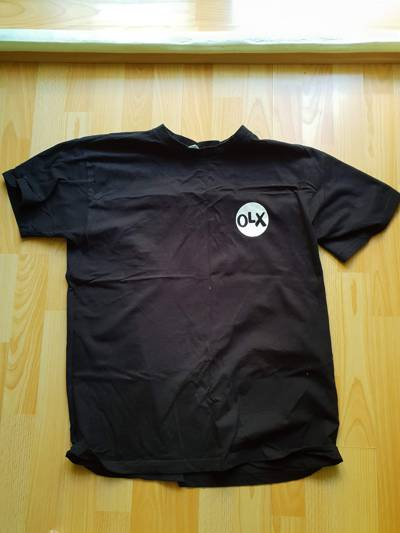

In [4]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [5]:
img = load_img(fullname, target_size=(299, 299))

In [6]:
x = np.array(img)
x.shape

(299, 299, 3)

## 8.3 Pre-trained convolutional neural networks

* Imagenet dataset: https://www.image-net.org/
* Pre-trained models: https://keras.io/api/applications/


In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [8]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

In [9]:
X = np.array([x])

In [10]:
X.shape

(1, 299, 299, 3)

In [11]:
X = preprocess_input(X)

In [12]:
pred = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [13]:
decode_predictions(pred)

[[('n03595614', 'jersey', 0.68196297),
  ('n02916936', 'bulletproof_vest', 0.038140018),
  ('n04370456', 'sweatshirt', 0.03432482),
  ('n03710637', 'maillot', 0.011354224),
  ('n04525038', 'velvet', 0.0018453615)]]

## 8.4 Convolutional neural networks

* Types of layers: convolutional and dense 
* Convolutional layers and filters
* Dense layers

There are more layers. Read here: https://cs231n.github.io/

## 8.5 Tranfser learning

* Reading data with `ImageDataGenerator`
* Train `Xception` on smaller images (150x150)

(Better to run it with a GPU)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
#Keep conv layers, but not dense layers because it's very specific to that dataset.
# Transfering this knowledge to a new model is called "Transfer Learning"
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)
# target_size : size of the image
# batch_size : number of images to process at once

Found 3068 images belonging to 10 classes.


In [17]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [21]:
#train_ds is a generator
#It's a generator because it's not a list of images, it's a function that generates images
next(train_ds)

(array([[[[ 0.36470592,  0.19215691, -0.09803921],
          [ 0.3176471 ,  0.12941182, -0.15294117],
          [ 0.34901965,  0.14509809, -0.12941176],
          ...,
          [ 0.1686275 , -0.03529412, -0.29411763],
          [ 0.15294123, -0.05098039, -0.3098039 ],
          [ 0.10588241, -0.09803921, -0.35686272]],
 
         [[ 0.4039216 ,  0.2313726 , -0.05882353],
          [ 0.4431373 ,  0.254902  , -0.02745098],
          [ 0.3803922 ,  0.17647064, -0.09803921],
          ...,
          [ 0.18431377, -0.01960784, -0.27843136],
          [ 0.11372554, -0.09019607, -0.3490196 ],
          [ 0.09019613, -0.11372548, -0.372549  ]],
 
         [[ 0.4039216 ,  0.2313726 , -0.05882353],
          [ 0.38823533,  0.20000005, -0.08235294],
          [ 0.41176474,  0.20784318, -0.06666666],
          ...,
          [ 0.1686275 , -0.03529412, -0.29411763],
          [ 0.09803927, -0.10588235, -0.36470586],
          [ 0.07450986, -0.12941176, -0.38823527]],
 
         ...,
 
         [[ 

In [22]:
X, y = next(train_ds)

In [23]:
#One Hot Encoding, this is how we do multi-class classification.
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [28]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 341 images belonging to 10 classes.


## Diagram of the process
![diagram](images/diagram.PNG)

In [29]:
#In keras terminology, top: Dense Layers, Bottom: Convolutional Layers
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
# We didn't include top because we doesn't care about dense Layers.

#We don't want to change convolutional layers, so we put base_model.trainable to False (freezed)
base_model.trainable = False

#inputs is in batch (3 channels)
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
#Apply pooling to base 
vectors = keras.layers.GlobalAveragePooling2D()(base)
#10 because we have 10 classes.
outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [30]:
## Training the model
learning_rate = 0.01
## Adam is the recommended algorithm to use
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [31]:
#Epoch: how many times go over the data.
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 98s 990ms/step - loss: 1.2266 - accuracy: 0.6754 - val_loss: 1.0675 - val_accuracy: 0.7155
Epoch 2/10
96/96 [==============================] - 97s 1s/step - loss: 0.5638 - accuracy: 0.8266 - val_loss: 0.9355 - val_accuracy: 0.7771
Epoch 3/10
96/96 [==============================] - 91s 945ms/step - loss: 0.3863 - accuracy: 0.8673 - val_loss: 0.8603 - val_accuracy: 0.7947
Epoch 4/10
96/96 [==============================] - 96s 1s/step - loss: 0.2650 - accuracy: 0.9136 - val_loss: 0.8822 - val_accuracy: 0.8006
Epoch 5/10
96/96 [==============================] - 96s 1s/step - loss: 0.1630 - accuracy: 0.9420 - val_loss: 0.8839 - val_accuracy: 0.8065
Epoch 6/10
96/96 [==============================] - 93s 974ms/step - loss: 0.1110 - accuracy: 0.9602 - val_loss: 0.9565 - val_accuracy: 0.7859
Epoch 7/10
96/96 [==============================] - 94s 980ms/step - loss: 0.0547 - accuracy: 0.9840 - val_loss: 0.9398 - val_accuracy: 0.7918
Epoch 8/

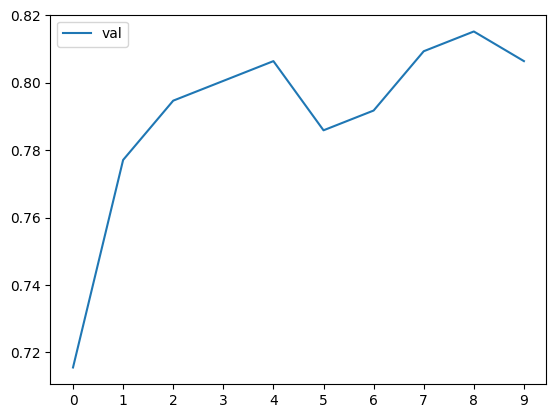

In [32]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## 8.6 Adjusting the learning rate

* What's the learning rate,
    Example: How fast you read
    Validation will be how you apply what you've read.

    You read many books in one year, but you don't remember what you learned. High learning rate, too fast.
    -   Validation: Poorly (Overfit)
  
    You read 4 books and you remember quite all of them. Medium learning rate, ok speed.
    -   Validation: Good (Ok)
  
    You read one book in one year, but you remember everything. Low learning rate, very effective but slow.
    -   Validation: Poorly (because you have a problem not related to the book that you've read.) (underfit)


* Trying different values

In [33]:
def make_model(learning_rate=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [34]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
96/96 [==============================] - 88s 895ms/step - loss: 1.9141 - accuracy: 0.3556 - val_loss: 1.5509 - val_accuracy: 0.5249
Epoch 2/10
96/96 [==============================] - 88s 915ms/step - loss: 1.3719 - accuracy: 0.5698 - val_loss: 1.2152 - val_accuracy: 0.6246
Epoch 3/10
96/96 [==============================] - 87s 911ms/step - loss: 1.1346 - accuracy: 0.6450 - val_loss: 1.0396 - val_accuracy: 0.7038
Epoch 4/10
96/96 [==============================] - 92s 957ms/step - loss: 0.9968 - accuracy: 0.6897 - val_loss: 0.9278 - val_accuracy: 0.7302
Epoch 5/10
96/96 [==============================] - 86s 894ms/step - loss: 0.9055 - accuracy: 0.7128 - val_loss: 0.8616 - val_accuracy: 0.7566
Epoch 6/10
96/96 [==============================] - 87s 907ms/step - loss: 0.8386 - accuracy: 0.7278 - val_loss: 0.8071 - val_accuracy: 0.7537
Epoch 7/10
96/96 [==============================] - 88s 913ms/step - loss: 0.7868 - accuracy: 0.7415 - val_loss: 0.7710 - val_accuracy:

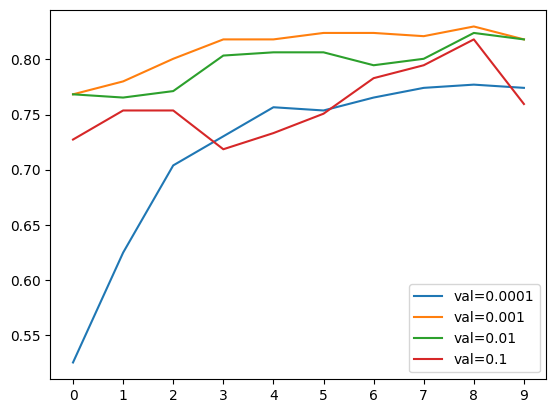

In [35]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [36]:
#Worst scores
del scores[0.1]
del scores[0.0001]

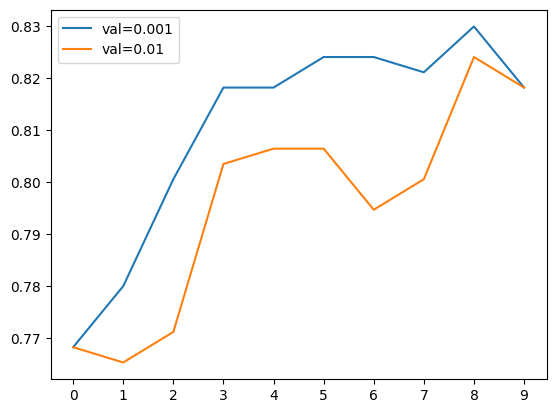

In [38]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

In [37]:
learning_rate = 0.001

## 8.7 Checkpointing

* Saving the best model only
* Training a model with callbacks

In [39]:
model.save_weights('model_v1.h5', save_format='h5')

In [40]:
#After one epoch is over we can invoke callback and do whatever we want
chechpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [79]:
learning_rate = 0.001

model = make_model(learning_rate=learning_rate)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[chechpoint]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 96 steps, validate for 11 steps
Epoch 1/10
96/96 [==============================] - 21s 216ms/step - loss: 1.1353 - accuracy: 0.6170 - val_loss: 0.7258 - val_accuracy: 0.7801
Epoch 2/10
96/96 [==============================] - 16s 168ms/step - loss: 0.6469 - accuracy: 0.7735 - val_loss: 0.6332 - val_accuracy: 0.7859
Epoch 3/10
96/96 [==============================] - 16s 169ms/step - loss: 0.5182 - accuracy: 0.8243 - val_loss: 0.5905 - val_accuracy: 0.8094
Epoch 4/10
96/96 [==============================] - 16s 170ms/step - loss: 0.4390 - accuracy: 0.8553 - val_loss: 0.5550 - val_accuracy: 0.8152
Epoch 5/10
96/96 [==============================] - 16s 170ms/step - loss: 0.3827 - accuracy: 0.8827 - val_loss: 0.5437 - val_accuracy: 0.8211
Epoch 6/10
96/96 [==============================] - 16s 170ms/step - loss: 0.3342 - accuracy: 0.8990 - val_loss: 0.5319 - val_accuracy: 0.8358
Epoch 7/10
96/96 [==============================] 

## 8.8 Adding more layers


* Adding one inner dense layer
* Experimenting with different sizes of inner layer

In [3]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [13]:
learning_rate = 0.001

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
83689472/83683744 [==============================] - 1s 0us/step
[2021-11-03 13:35:43.005 ip-172-16-64-149:21634 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-11-03 13:35:43.104 ip-172-16-64-149:21634 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 96 steps, validate for 11 steps
Epoch 1/10
96/96 [==============================] - 42s 438ms/step - loss: 1.1849 - accuracy: 0.6033 - val_loss: 0.8076 - val_accuracy: 0.7243
Epoch 2/10
96/96 [==============================] - 16s 169ms/step - loss: 0.7314 - accuracy: 0.7474 - val_loss: 0.7305 - val_accuracy: 0.7507
Epoch 3/10
96/96 [==============================] - 16s 169ms/step - loss: 0.5834 - accuracy: 0.8018 - val_loss: 0.6308 - val_accuracy: 0.7889
Epoch 4/10
96/96 [==============================] - 16s 170ms/step - loss: 0.4878 - accuracy: 0.8370 - val_loss: 0.6715 - val_accuracy: 

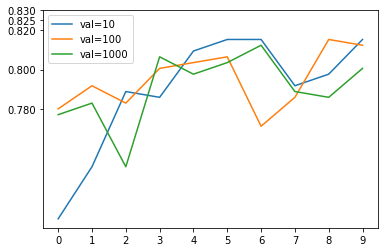

In [16]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

## 8.9 Regularization and dropout

* Regularizing by freezing a part of the network
* Adding dropout to our model
* Experimenting with different values

In [8]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [13]:
learning_rate = 0.001
size = 100

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
[2021-11-03 21:19:20.707 ip-172-16-13-140:18999 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-11-03 21:19:20.814 ip-172-16-13-140:18999 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 96 steps, validate for 11 steps
Epoch 1/30
96/96 [==============================] - 56s 583ms/step - loss: 0.9642 - accuracy: 0.6747 - val_loss: 0.6832 - val_accuracy: 0.7566
Epoch 2/30
96/96 [==============================] - 15s 158ms/step - loss: 0.5163 - accuracy: 0.8230 - val_loss: 0.6058 - val_accuracy: 0.7918
Epoch 3/30
96/96 [==============================] - 15s 160ms/step - loss: 0.3458 - accuracy: 0.8885 - val_loss: 0.5577 - val_accuracy: 0.8270
Epoch 4/30
96/96 [==============================] - 15s 161ms/step - loss: 0.2575 - accuracy: 0.9218 - val_loss: 0.5166 - val_accuracy: 0.8416
Epoch 5/30
96/96 [==============================] - 15s 1

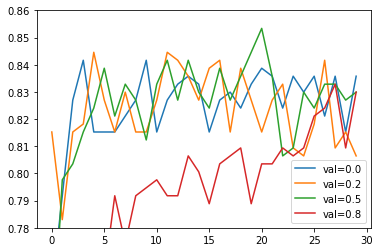

In [16]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.78, 0.86)
plt.legend()

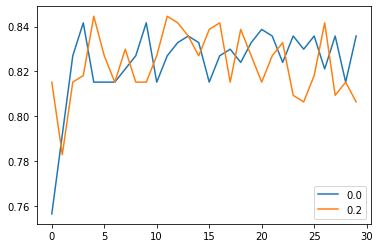

In [23]:
hist = scores[0.0]
plt.plot(hist['val_accuracy'], label=0.0)

hist = scores[0.2]
plt.plot(hist['val_accuracy'], label=0.2)

plt.legend()
#plt.plot(hist['accuracy'], label=('val=%s' % droprate))

## 8.10 Data augmentation

* Different data augmentations
* Training a model with augmentations
* How to select data augmentations?

In [17]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     vertical_flip=True,
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(150, 150),
    batch_size=32
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [18]:
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 96 steps, validate for 11 steps
Epoch 1/50
96/96 [==============================] - 19s 200ms/step - loss: 1.0738 - accuracy: 0.6346 - val_loss: 0.6670 - val_accuracy: 0.7859
Epoch 2/50
96/96 [==============================] - 16s 162ms/step - loss: 0.6210 - accuracy: 0.7846 - val_loss: 0.5732 - val_accuracy: 0.8182
Epoch 3/50
96/96 [==============================] - 16s 162ms/step - loss: 0.4573 - accuracy: 0.8387 - val_loss: 0.5620 - val_accuracy: 0.8182
Epoch 4/50
96/96 [==============================] - 15s 161ms/step - loss: 0.3637 - accuracy: 0.8797 - val_loss: 0.5376 - val_accuracy: 0.8094
Epoch 5/50
96/96 [==============================] - 16s 162ms/step - loss: 0.2951 - accuracy: 0.9042 - val_loss: 0.5465 - val_accuracy: 0.8065
Epoch 6/50
96/96 [==============================] - 16s 162ms/step - loss: 0.2348 - accuracy: 0.9283 - val_loss: 0.6016 - val_accuracy: 0.7918
Epoch 7/50
96/96 [==============================] 

KeyboardInterrupt: 

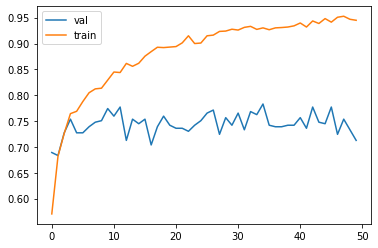

In [12]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')

plt.legend()

## 8.11 Training a larger model

* Train a 299x299 model

In [19]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(10)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [25]:
input_size = 299

In [38]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/train',
    target_size=(input_size, input_size),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './clothing-dataset-small/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [39]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [40]:
learning_rate = 0.0005
size = 100
droprate = 0.2

model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 96 steps, validate for 11 steps
Epoch 1/50
96/96 [==============================] - 78s 816ms/step - loss: 1.0387 - accuracy: 0.6793 - val_loss: 0.5567 - val_accuracy: 0.8211
Epoch 2/50
96/96 [==============================] - 77s 805ms/step - loss: 0.5472 - accuracy: 0.8214 - val_loss: 0.4331 - val_accuracy: 0.8622
Epoch 3/50
96/96 [==============================] - 74s 772ms/step - loss: 0.4525 - accuracy: 0.8491 - val_loss: 0.4360 - val_accuracy: 0.8504
Epoch 4/50
96/96 [==============================] - 75s 778ms/step - loss: 0.4000 - accuracy: 0.8605 - val_loss: 0.3728 - val_accuracy: 0.8856
Epoch 5/50
96/96 [==============================] - 75s 785ms/step - loss: 0.3586 - accuracy: 0.8853 - val_loss: 0.3832 - val_accuracy: 0.8768
Epoch 6/50
96/96 [==============================] - 75s 777ms/step - loss: 0.3261 - accuracy: 0.8934 - val_loss: 0.3828 - val_accuracy: 0.8827
Epoch 7/50
96/96 [==============================] 

KeyError: 'val_accuracy'

## 8.12 Using the model

* Loading the model
* Evaluating the model
* Getting predictions

In [3]:
import tensorflow as tf
from tensorflow import keras

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

In [7]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    './clothing-dataset-small/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 372 images belonging to 10 classes.


In [11]:
model = keras.models.load_model('xception_v4_1_13_0.903.h5')

In [10]:
model.evaluate(test_ds)

  ...
    to  
  ['...']
12/12 [==============================] - 8s 645ms/step - loss: 0.2939 - accuracy: 0.8978


[0.29389633300403756, 0.89784944]

In [12]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'

In [15]:
img = load_img(path, target_size=(299, 299))

In [16]:
import numpy as np

In [18]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [21]:
X = preprocess_input(X)

In [23]:
pred = model.predict(X)

In [25]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]

In [26]:
dict(zip(classes, pred[0]))

{'dress': -1.4282539,
 'hat': -5.522186,
 'longsleeve': -3.1655293,
 'outwear': -2.201648,
 'pants': 9.294684,
 'shirt': -3.4289198,
 'shoes': -4.2395606,
 'shorts': 3.4339347,
 'skirt': -4.194675,
 't-shirt': -2.9939806}

## 8.13 Summary

* We can use pre-trained models for general image classification
* Convolutional layers let us turn an image into a vector
* Dense layers use the vector to make the predictions
* Instead of training a model from scratch, we can use transfer learning and re-use already trained convolutional layers
* First, train a small model (150x150) before training a big one (299x299)
* Learning rate - how fast the model trians. Fast learners aren't always best ones
* We can save the best model using callbacks and checkpointing
* To avoid overfitting, use dropout and augmentation

## 8.14 Explore more

* Add more data, e.g. Zalando, etc (ADD LINKS)
* Albumentations - another way of generating augmentations
* Use PyTorch or MXNet instead of TensorFlow/Keras
* In addition to Xception, there are others architectures - try them 

Other projects:

* cats vs dogs
* Hotdog vs not hotdog
* Category of images

